<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_4_cnn_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 11 - Redes Neurais Convolucionais

## 11.4 - Redes Neurais Convolucionais em Textos

O objetivo deste notebook é detalhar como utilizar redes neurais convolucionais e camadas associadas em textos. Como as redes neurais devem receber entradas numéricas, temos que pré-processar os textos de forma a garantir que seus termos estejam representados por números e que os textos estejam sob uma forma estruturada de mesmo tamanho (lembre-se que textos podem ter diferentes quantidades de palavras). 

In [ ]:
!pip install keras
!pip install tensorflow

In [2]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,MaxPooling1D,Activation,Flatten,Dropout,BatchNormalization
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

### Carregamento do corpus para Pandas DataFrames

PS.: Mais informações sobre a divisão de um conjunto de dados em treinamento, validação e teste, você encontra nesse link.

In [3]:
path_train = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013train-A.txt'
path_test = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013test-A.txt'
path_valid = 'https://raw.githubusercontent.com/viniciusrpb/cic0269_natural_language_processing/main/datasets/corpora/tweets_polarity_classification/twitter-2013dev-A.txt'

df_train = pd.read_csv(path_train,names=['id','polarity','text'],sep='\t')
df_valid = pd.read_csv(path_valid,names=['id','polarity','text'],sep='\t')
df_test = pd.read_csv(path_test,names=['id','polarity','text'],sep='\t')

In [4]:
print(f'Train size {df_train.shape}')
print(f'Valid size {df_valid.shape}')
print(f'Test size {df_test.shape}')

Train size (9684, 3)
Valid size (1654, 3)
Test size (3547, 3)


In [5]:
df_train = df_train.drop(labels=['id'],axis=1)
df_valid = df_valid.drop(labels=['id'],axis=1)
df_test = df_test.drop(labels=['id'],axis=1)

Geração dos Logits dos labels utilizando a função to_categorical do Tensorflow:

In [6]:
df_train['polarity'] = pd.Categorical(df_train['polarity'])
y_train_int = df_train['polarity'].cat.codes

df_valid['polarity'] = pd.Categorical(df_valid['polarity'])
y_valid_int = df_valid['polarity'].cat.codes

df_test['polarity'] = pd.Categorical(df_test['polarity'])
y_test_int = df_test['polarity'].cat.codes

In [7]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

### Numericalização

Esse é o processo de transformar as palavras de um texto em números. Por exemplo: os textos

1.   "Eu quero jogar futebol"
2.   "Não dá para assistir futebol"
3.   "Não vou jogar meu boné fora"

Constrói-se o vocabulário com índices:

1. eu
2. quero
3. jogar
4. futebol
5. não
6. dá
7. para
8. assistir
9. vou
10. jogar
11. meu
12. boné
13. fora

Assim, a geração do vocabulário do *corpus* de treinamento **deve ser feita apenas para os textos de treinamento**, já que eles são conhecidos para os modelos de linguagem e de classificação:

In [8]:
train_tweets = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_tweets)):
    train_tweets[i] = train_tweets[i].lower()
    for word in train_tweets[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [9]:
vocab_size = len(vocabulary)

Outra possibilidade consiste em utilizar a classe [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) do tensorflow.

In [10]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['text'])

Com o word_index é possível ver o vocabulário e os índices de cada palavra:

In [11]:
word_index = tokenizer.word_index
print(f"{word_index['blue']} is the index of word 'blue'")
print(f"{word_index['launch']} is the index of word 'launch'")

919 is the index of word 'blue'
865 is the index of word 'launch'


O próximo passo consiste em transformar as palavras em números de acordo com os índices do vocabulário. É o último passo da numericalização, em que se obtém um vetor de números inteiros a partir de um tweet de entrada. Fazendo-se para os textos de treinamento, tem-se que:

In [12]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])

Veja o resultado para um dos tweets de treinamento:

In [13]:
print(f"Tweet: {df_train['text'][0]}")
print('Tweet numericalizado: ')
print(train_sequences[0])
print(f'Quantidade de palavras no tweet: {len(train_sequences[0])}')

Tweet: Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)
Tweet numericalizado: 
[2711, 68, 22, 191, 383, 72, 2909, 4, 57, 31, 2, 1966, 1127, 6, 115]
Quantidade de palavras no tweet: 15


Acontece que os tweets podem variar na quantidade de palavras e as redes neurais não processam os tweets representados em estruturas de dimensões distintas. Veja um outro exemplo de tweet de treinamento:

In [14]:
print(f"Tweet: {df_train['text'][2]}")
print('Tweet numericalizado: ')
print(train_sequences[2])
print(f'Quantidade de palavras no tweet: {len(train_sequences[2])}')

Tweet: its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.
Tweet numericalizado: 
[141, 61, 23, 4, 57, 8, 5680, 475, 3, 4, 30, 574, 501, 2177, 55, 35, 103, 10, 269]
Quantidade de palavras no tweet: 19


### Pós-processamento da numericalização

Vamos tornar todos os vetores numéricos acrescentando-se zeros ao final, precisamos fixar um tamanho para os vetores numéricos resultantes da numericalização.

Uma estratégia consiste em calcular a quantidade de tweets que existe para cada quantidade possível de palavras. Supondo que o tweets pós-processados não possuirão mais do que $50$ palavras, montamos o seguinte histograma:

In [15]:
max_words = 50

hist = {}

hist['qtde'] = [x for x in range(0,max_words)]

lista = [0]*(max_words)
for x in train_sequences:
    lista[len(x)]+=1

hist['num tweets'] = lista

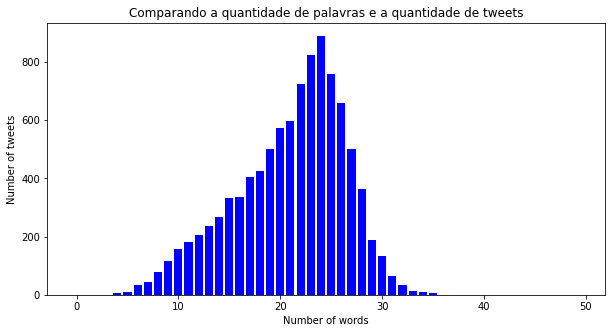

In [16]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hist['qtde'],hist['num tweets'],
        color ='blue')
 
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
plt.title("Comparando a quantidade de palavras e a quantidade de tweets")
plt.show()

Pode-se verificar que grande parte dos tweets do treinamento possui entre 10 e 30 palavras. Por isso, vamos ajustar o tamanho dos vetores numericalizados como 32:

In [17]:
max_length = 32

Assim, tweets cujos vetores numericalizados possuírem menos do que 32 palavras serão completados com zeros. Tweets que possuírem mais do que 32 palavras serão truncados (terão algumas palavras removidas)

A função que faz essas operações de truncamento e de padding é [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences). Ajustamos a seguir o tipo de truncamento (se é no início ou no final) e o padding (inclusão de zeros ocorre no início ou no final):

In [18]:
trunc_type = 'post'
padding_type = 'post'

Agora vai...

In [19]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Veja o resultado em que todos os vetores "padded" possuem tamanho $32$:

In [20]:
print('Tweet:')
print(df_train['text'][0])
print('\nVetor numericalizado do tweet:')
print(train_sequences[0])
print('\nVetor numericalizado pós-processado com padding e truncamento:')
print(train_padded[0])

Tweet:
Gas by my house hit $3.39!!!! I\u2019m going to Chapel Hill on Sat. :)

Vetor numericalizado do tweet:
[2711, 68, 22, 191, 383, 72, 2909, 4, 57, 31, 2, 1966, 1127, 6, 115]

Vetor numericalizado pós-processado com padding e truncamento:
[2711   68   22  191  383   72 2909    4   57   31    2 1966 1127    6
  115    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [21]:
print('Tweet:')
print(df_train['text'][2])
print('\nVetor numericalizado do tweet:')
print(train_sequences[2])
print('\nVetor numericalizado pós-processado com padding e truncamento:')
print(train_padded[2])

Tweet:
its not that I\u2019m a GSP fan\u002c i just hate Nick Diaz. can\u2019t wait for february.

Vetor numericalizado do tweet:
[141, 61, 23, 4, 57, 8, 5680, 475, 3, 4, 30, 574, 501, 2177, 55, 35, 103, 10, 269]

Vetor numericalizado pós-processado com padding e truncamento:
[ 141   61   23    4   57    8 5680  475    3    4   30  574  501 2177
   55   35  103   10  269    0    0    0    0    0    0    0    0    0
    0    0    0    0]


Finalmente, temos que numericalizar os tweets de validação e de testes:

In [22]:
valid_sequences = tokenizer.texts_to_sequences(df_valid['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Arquitetura da Rede Neural Convolucional Profunda (RNCP)

Começamos pela camada de entrada da RNCP. Poderíamos até colocar os vetores numericalizados ou one-hot encoding como entrada da rede (utilizando a camada de [Input](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)), mas trata-se de um espaço esparso que é difícil de identificar relacionamentos entre as palavras (Fonte: [Word Embeddings Tensorflow](https://www.tensorflow.org/text/guide/word_embeddings)).

Por isso, uma abordagem mais apropriada trata-se da criação de word embeddings de tamanho fixo. Nessa representação, cada palavra é representada por um vetor de tamanho $n$ em que palavras similares em relação a um contexto possuem valores (codificação) parecidas:



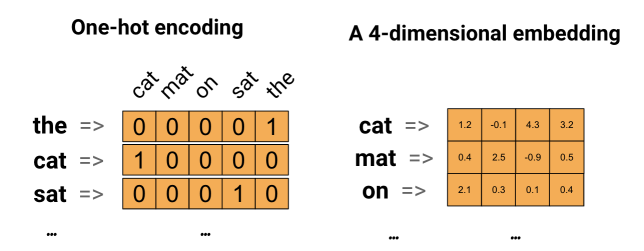

Podemos utilizar uma camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding), que possui pesos inicializados aleatoriamente e que são ajustados durante o treinamento via backpropagation. A embedding layer recebe como entrada uma matriz de dimensões *batch_size* $\times$ *input_length* e gera como saída uma matriz de *batch_size* $\times$ *output_dim*.

No exemplo abaixo, vamos criar um embedding que recebe uma entrada quatro instâncias contendo uma palavra cada. Assim, os parâmetros do objeto *Embedding* são ajustados como:

*   dimensão da entrada (```input_dim```): O vetor de entrada é descrito por em um espaço de características de 4 dimensões. Por exemplo, o vocabulário de um corpus de treinamento, em que cada palavra é um eixo desse espaço;
*   comprimento da entrada (```input_length```): quantidade de palavras (números) no vetor de entrada. Por exemplo, a quantidade total de palavras de um texto;
*   dimensão da saída (```output_dim```): vamos gerar um vetor de 16 dimensões para cada número da instância da entrada.



In [23]:
n = 16

embedding_model = Sequential()
embedding_model.add(Embedding(input_dim = 4,output_dim = n, input_length = 2))

Veja como a predição ocorre para três vetores de entrada, cada um composto por duas palavras:

In [24]:
preds = embedding_model.predict([[3,1],[2,0],[1,1]])
print(preds)

[[[-0.03738808 -0.01555153  0.01267136  0.02722342  0.0076576
    0.00764887  0.00492281  0.01170427 -0.00802235  0.02911219
   -0.0155543   0.04267925  0.03391931 -0.01232327 -0.00943492
    0.02474544]
  [-0.01647995  0.01380012  0.04392635 -0.01922065 -0.01734706
   -0.0153716  -0.02368927 -0.00586349  0.04357848  0.02374974
   -0.02012072  0.01302186 -0.03841271  0.02272666  0.01341662
    0.00260087]]

 [[-0.04955786 -0.03345659  0.022073   -0.00538725 -0.02730136
   -0.04410125  0.04446191 -0.00538515  0.02903019  0.00852995
    0.01167786 -0.02818509  0.02656514  0.04522653 -0.01819725
    0.03533561]
  [ 0.03563949 -0.04505098 -0.00352506  0.03791815 -0.00921858
   -0.0410561  -0.03654842 -0.00542773 -0.03253347 -0.02154924
    0.02824259 -0.01819972 -0.03610264 -0.04260318  0.02475048
    0.00755868]]

 [[-0.01647995  0.01380012  0.04392635 -0.01922065 -0.01734706
   -0.0153716  -0.02368927 -0.00586349  0.04357848  0.02374974
   -0.02012072  0.01302186 -0.03841271  0.02272666 

Voltando para o problema de classificação de polaridade de tweets, vamos gerar embeddings de dimensão 32:

In [25]:
n = 32

Agora vamos implementar a arquitetura da nossa rede:



*   Camada [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D): realiza a operação de convolução como mostra a imagem abaixo (observe a existência de *padding* nas bordas do sinal de entrada - vetor com linhas escuras):





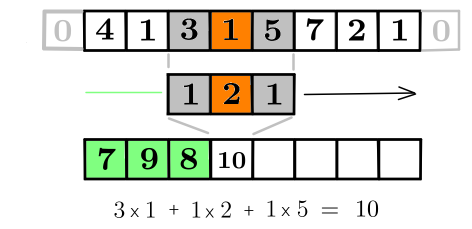

*   Camada [MaxPooling1D](https://keras.io/api/layers/pooling_layers/max_pooling1d/) ou [AveragePooling1D](https://keras.io/api/layers/pooling_layers/average_pooling1d/): funciona da mesma maneira que as camadas Max Pooling 2D, reduzindo a dimensão dos vetores conforme o parâmetro de stride. Existem também as variações *Minimum Pooling (MinPool1D)* e *Average Pooling (AvgPooling)*. A figura abaixo ilustra o processamento de um max pooling com ```pool_size = 2```.

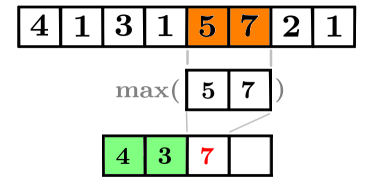

*   Camada [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) ou [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D): seleciona o maior valor em uma entrada como mostra a figura abaixo, que ilustra o *Global Max Pooling*.

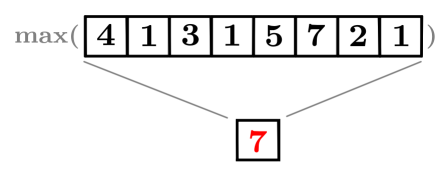

**Importante:** Em imagens, é muito comum utilizar a camada *Flatten*. Assim, qual é a diferença entre Flatten() e *GlobalxxxPooling1D*, em que *xxx* $\in \{ Max, Min, Average\}$?

 Suponha que temos a seguinte entrada (*batch_size*,$m$,$n$) em que $m$ e $n$ são números inteiros. Veja como fica as saídas nas seguintes camadas:

*   *Flatten*: (*batch_size*,$m \times n$)
*   *GlobalxxxPooling1D*: (*batch_size*, 1,1)

Para textos, o uso de *Flatten* e *GlobalxxxPooling1D* possuem o mesmo efeito quando a entrada para qualquer uma dessas camadas é (*batch_size*,$k$), em que $k$ é um inteiro. 

### Definindo a Arquitetura

De qualquer maneira, temos a seguinte arquitetura, em que os hiperparâmetros (número de filtros, kernel_size, strides) foram ajustados aleatoriamente, com exceção da Embedding Layer, que foi ajustada com os seguintes detalhes:



*  ```input_dim = vocab_size```: o espaço de características one hot encoding que é passado na entrada possui ```vocab_size``` dimensões;
*  ```output_dim = n```: a dimensionalidade de saída do word embedding é ajustado para $n$;
*  ```input_length = max_length```: o tamanho de cada *tweet* foi truncado para *max_length* palavras;

Veja também onde está a camada *GlobalMaxPooling1D*. Lembre-se que na camada anterior, a Conv1D recebe um *tweet* em sua forma numericalizada e truncada, e gera ```filters``` mapas de ativação. Por isso, a operação de *GlobalMaxPooling1D* nesses    que o total de *tweets* por *batch* é igual a *batch_size*.



In [26]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = n, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=11, padding='same',strides=1))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 32)            1161472   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           45184     
                                                                 
 activation (Activation)     (None, 32, 128)           0         
                                                                 
 batch_normalization (BatchN  (None, 32, 128)          512       
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)              

Vamos treinar o modelo utilizando um ```batch_size=32``` e em $50$ épocas:

In [27]:
sgd = SGD(learning_rate=0.000001)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history_fine = model.fit(train_padded,y_train,
                         validation_data=(valid_padded,y_valid),
                         epochs=100,
                         batch_size=32)

Epoch 1/100
303/303 [==============================] - 9s 27ms/step - loss: 1.2583 - accuracy: 0.3580 - val_loss: 1.0924 - val_accuracy: 0.4075
Epoch 2/100
303/303 [==============================] - 9s 28ms/step - loss: 1.2439 - accuracy: 0.3647 - val_loss: 1.0752 - val_accuracy: 0.4135
Epoch 3/100
303/303 [==============================] - 9s 30ms/step - loss: 1.2140 - accuracy: 0.3840 - val_loss: 1.0691 - val_accuracy: 0.4154
Epoch 4/100
303/303 [==============================] - 6s 19ms/step - loss: 1.1992 - accuracy: 0.3968 - val_loss: 1.0683 - val_accuracy: 0.4232
Epoch 5/100
303/303 [==============================] - 5s 15ms/step - loss: 1.1924 - accuracy: 0.3992 - val_loss: 1.0682 - val_accuracy: 0.4268
Epoch 6/100
303/303 [==============================] - 5s 15ms/step - loss: 1.1955 - accuracy: 0.4041 - val_loss: 1.0689 - val_accuracy: 0.4317
Epoch 7/100
303/303 [==============================] - 5s 15ms/step - loss: 1.1955 - accuracy: 0.4044 - val_loss: 1.0699 - val_accuracy:

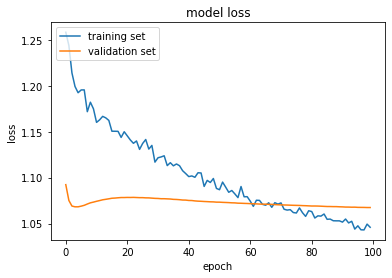

In [28]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

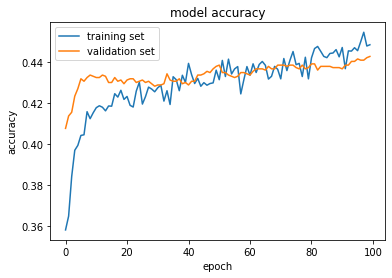

In [29]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Avaliação com os Dados de Teste

In [30]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)

In [31]:
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       559
           1       0.43      0.86      0.57      1513
           2       0.43      0.15      0.23      1475

    accuracy                           0.43      3547
   macro avg       0.29      0.34      0.27      3547
weighted avg       0.36      0.43      0.34      3547



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
